1. Import libraries

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.linear_model import Ridge, Lasso
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import make_scorer

2. Define functions to load data, create features

In [10]:
def create_features(df):
    df['Spread'] = df['High'] - df['Low']
    df['Gap'] = df['Open'] - df['Close'].shift(1)
    df['Intraday'] = df['Open'] - df['Close']
    return df

def drop_features(df):
    df.drop(columns=['Spread',
                     'Gap',
                     'Intraday',
                     ],
            inplace=True)

    df.drop(columns=['Open','High','Low','Close','Volume','Adj Close',
                     ], inplace=True)
    return df

def process_features(df, lookback, step):
    for i in range(step, lookback+1, step):
        df['%d Spread' % (i)] = df['Spread'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Spread' % (i)] = df['Spread'].rolling(window=i).mean()

        df['%d Gap' % (i)] = df['Gap'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Gap' % (i)] = df['Gap'].rolling(window=i).mean()

        df['%d Intraday' % (i)] = df['Intraday'].pct_change(periods=i, fill_method=None)
        df['%d Rolling Avg Intraday' % (i)] = df['Intraday'].rolling(window=i).mean()
    return df

def features(df, lookback, step):
    create_features(df)
    process_features(df, lookback, step)
    drop_features(df)
    return df

3. Create a function to create a target.

In [11]:
def create_target(df, lookforward=2, target='Open'):
    df['Target'] = np.log(df[target].shift(periods=-lookforward)/df[target].shift(periods=-1))
    return df

4. Create a custom scoring function.

In [12]:
def custom_score(y_true, y_pred):
  pred_sign = np.sign(y_pred)
  y_true = np.squeeze(y_true)
  returns = np.where((pred_sign == 1), y_true, 0)
  return returns.mean()

custom_scorer = make_scorer(custom_score, greater_is_better=True)

With this scoring function, we are scoring different models on their average returns, as opposed to the normal scoring function of a regression model, which would be R^2 or RMSE, both of which are fine if we were predicting price, but accurately predicting price =/= good returns. So instead we just score the models directly on their average returns.

5. Define the models we are going to use

In [13]:
estimator1 = Ridge()
estimator2 = Lasso(alpha=.001)
estimator3 = KNeighborsRegressor()
models = [estimator1,estimator2,estimator3]
estimator = VotingRegressor(estimators=[('Ridge', estimator1),
                                        ('Lasso', estimator2),
                                        ('KNN', estimator3),
                                        ])

We combine the 3 models into 1 using the VotingRegressor. The VotingRegressor works by averaging the output of the models that its composed of into a single output. Go to this link for more info: https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.VotingRegressor.html

6. Define target, cross validation folds, interval, and lookback parameters.

In [14]:
lookforward = 2
tscv = TimeSeriesSplit(n_splits=5, gap=lookforward)
steps = [1, 2, 3, 4, 5]
lookbacks = [1, 2, 3, 4, 5]
cv_results = pd.DataFrame(columns=['step', 'lookback', 'score'])

To make sure the strategy our models come up with are actually significant, and not just a memorization of the data we gave it, we test the model 5 times (n_splits=5). We also have to add a gap between each split, otherwise there will be some overlap, which could cause the models to peek at data it shouldn't, and artificially inflate its score. Next we define the steps (or intervals) and lookbacks we want to test our model at, in order to find the ones that it scores the highest on. Lastly, we create an object to store the results of our model in.

7. Evaluate and visualize scores of different combinations of parameters

In [ ]:
for step in steps:
    for lookback in lookbacks:
        if lookback >= step:
            spy = yf.download('SPY', start='2004-01-01')
            agg = yf.download('AGG', start='2004-01-01')

            spy = create_target(spy, lookforward, target='Open')

            spy = features(spy, lookback, step)
            spy = spy.add_suffix(' SPY')
            agg = features(agg, lookback, step)
            agg = agg.add_suffix(' AGG')
            cv = pd.merge(spy, agg, how='inner', on='Date')

            cv.drop(cv.tail(lookforward).index, inplace=True)
            cv.drop(cv.head(lookback).index, inplace=True)
            X = cv
            y = X[['Target SPY']]
            X = X.drop(columns=['Target SPY'])
            X.fillna(method="ffill", inplace=True)
            X.replace([np.inf, -np.inf], 0, inplace=True)
            X.fillna(0, inplace=True)

            cv_score = cross_val_score(estimator=estimator, X=X, y=y,
                                       scoring=custom_scorer,
                                       cv=tscv, verbose=0)

            cv_results = cv_results.append({'step': step, 'lookback': lookback, 'score': cv_score.mean()}, ignore_index=True)

8. Visualize results in a heatmap

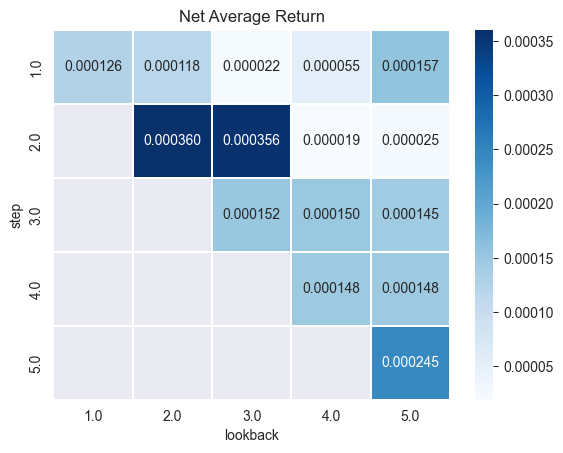

In [16]:
cv_results = cv_results.pivot(index='step', columns='lookback', values='score')
sns.heatmap(cv_results, annot=True, fmt='.6f', linewidths=.25, cmap='Blues')
plt.title('Net Average Return')
plt.show()

Here we can see a 2 period step interval with a maximum look back of 2 periods performs the best. In the next notebook, we will adjust the parameters of the models

BONUS: Back test best parameters

In [ ]:
# !pip3 install backtesting
from backtesting import Strategy, Backtest
from sklearn.model_selection import train_test_split

In [22]:
step = 2
lookback = 2

spy = yf.download('SPY', start='2004-01-01')
agg = yf.download('AGG', start='2004-01-01')

spy = create_target(spy, lookforward, target='Open')

spy = features(spy, lookback, step)
spy = spy.add_suffix(' SPY')
agg = features(agg, lookback, step)
agg = agg.add_suffix(' AGG')
cv = pd.merge(spy, agg, how='inner', on='Date')

cv.drop(cv.tail(lookforward).index, inplace=True)
cv.drop(cv.head(max(lookbacks)).index, inplace=True)
X = cv
y = X[['Target SPY']]
X = X.drop(columns=['Target SPY'])
X.fillna(method="ffill", inplace=True)
X.replace([np.inf, -np.inf], 0, inplace=True)
X.fillna(0, inplace=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.85, shuffle=False)
X_test = X_test.iloc[(abs(lookforward)):]
y_test = y_test.iloc[(abs(lookforward)):]

estimator.fit(X_train, y_train)
forecasted = estimator.predict(X_test)

data = yf.download('SPY', start='2004-01-01')
data.drop(data.tail(lookforward).index,inplace=True)
data.drop(data.head(lookback).index,inplace=True)
data = data.iloc[(-X_test.shape[0]):]
data['forecastedValue'] = forecasted
prediction = data

class MyStrategy(Strategy):
    Data = prediction

    def init(self):
        super().init()

    def next(self):
        if self.data.forecastedValue < 0:
            self.sell()
        elif self.data.forecastedValue > 0:
            self.buy()


bt = Backtest(prediction, MyStrategy,
              cash=1000,
              trade_on_close=False,
              exclusive_orders=True
              )
print(bt.run())
bt.plot(show_legend=False)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


[*********************100%***********************]  1 of 1 completed
Start                     2020-01-24 00:00:00
End                       2022-11-16 00:00:00
Duration                   1027 days 00:00:00
Exposure Time [%]                   99.718706
Equity Final [$]                  1303.298889
Equity Peak [$]                   1422.659027
Return [%]                          30.329889
Buy & Hold Return [%]               20.281664
Return (Ann.) [%]                    9.843686
Volatility (Ann.) [%]               24.604659
Sharpe Ratio                         0.400074
Sortino Ratio                        0.668303
Calmar Ratio                         0.449342
Max. Drawdown [%]                  -21.906877
Avg. Drawdown [%]                   -3.873366
Max. Drawdown Duration      546 days 00:00:00
Avg. Drawdown Duration       44 days 00:00:00
# Trades                                  709
Win Rate [%]                         50.77574
Best Trade [%]                       6.348897
Worst Trade

Row(id='3478', ...)

Before we evaluate the results, one thing to mention is that the result from this back test is cheating a little bit, since we evaluated this data when we used TimeSeriesSplit. In order to make sure what we have is a real strategy, we need to remove the amount we are going to back test first, lets say 15%, and then cross validate using TimeSeriesSplit with the rest 85%, this way, our model has no way to cheat since it hasn't seen the last 15%.

Onto the results, they seem to be great, but like we pointed out before, the model cheated a little bit, so in the next notebook we will take that into account and test it again after we optimize the parameters on the models and see how well it performs then.